# <strong> Example battery design: Automating BatPaC V5</strong>
   

The following notebook provides an example of the battery design module. The module uses BatPaC version 5 to solve the battery design based on user specific parameters and returns the material content of specific battery design. The notebook contains three examples:

* [Example 1: Single battery design](#first-bullet)
* [Example 2: Including vehicle parameters](#second-bullet)
* [Example 3: Several battery designs](#third-bullet)



<center><img src='../../docs/batpac_python.jpg' width=800/></center>

In [53]:
#Import required packages

import pandas as pd
import sys
import matplotlib.pyplot as plt
from tabulate import tabulate


#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd

#Local path to BatPaC version 5 - (8th March version!)
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 - 8March2022.xlsm"#ADD PATH

## Example 1 - Solving a single battery pack design <a class="anchor" id="first-bullet"></a>
The design of the Volkswagen MEB platform, 77 kWh version used in the ID.4 as reported by
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example. 


All BatPaC and several additional design parameters can be changed:

In [2]:
bd.print_battery_parameters()

,Parameter name,Parameter description,Type,Range,Default
Parameter family,,,,,
pack_demand_parameters,pack_energy,"Desired battery pack energy, kWh. Select one a...",Integer,None,NaN
pack_demand_parameters,pack_capacity,Desired battery pack capacity (Ah). Select one...,Integer,None,NaN
vehicle_parameters,total_packs,Total battery packs in vehicle,Integer,None,NaN
vehicle_parameters,packs_parallel_series,"If more than 1 pack, parellel or series",String,"P,S",NaN
vehicle_parameters,energy_udds_cycle,Energy requirement for a UDDS cycle (Wh/mile),Integer,None,NaN
...,...,...,...,...,...
cell_parameters,cell_thickness_terminal_neg,Thickness of the cell negative terminals,integer,None,NaN
cell_parameters,external_weld_lenght,"External weld tab length (default = 8), mm",integer,None,NaN
cell_parameters,feedthrough_lenght,"Feedthrough length (default = 5), mm",integer,None,NaN


For this example, we assume that the cells in the ID.4 are identical to the ID.3 and thereby use the ID.3 cell parameters as reported by [Günter and Wassiliadis (2022)](https://iopscience.iop.org/article/10.1149/1945-7111/ac4e11/meta). 




* usable battery energy: 94%
* cell type: prismatic
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G (NMC622 is used instead of NMC712, as the latter is not in the public version of BatPaC V5)
* Silicon additive anode: 0%
* Anode foil thickness: 12 um (Cu)
* Cathode foil thickness: 14 (Al)
* Separator thickness: 18 um
* Cathode coating thickness: 82.3
* Cells per module: 24
* Modules per pack: 12
* Cells in parallel: 3 
* Maximum charging time: 33 minutes (ev-database.org)
* Maximum charge power: 135 kW (ev-database.org)
<br>



All other parameters are BatPaC default parameters.

In [3]:
#Establish battery system class of specific design:
battery = bd.Battery_system (
                            vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',                              
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 18,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             pack_energy=82, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background. 
# #BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (
    batpac_path = path_batpac, 
    parameter_dict=parameter_dict, 
    visible=True
    )

In [4]:
from tabulate import tabulate

mc =  result_dict['material_content_pack']
cells = result_dict['general_battery_parameters']['cells_per_pack']



headers = [' ', 'BatPaC output', 'VW ID3.']
data = [
        ['Usable capacity (kWh)', result_dict['general_battery_parameters']['pack_usable_energy_kWh'], 77],
        ['Cell weight (kg)', round(mc['cell']/cells,3),1.100],
        ['Anode foil (gr)', round(mc['anode current collector Cu (12um)']/cells*1000,3), 64.6],
        ['Cathode foil (gr)', round(mc['cathode current collector Al (14um)']/cells*1000,3), 30.5],
        ['Anode coating (gr)', round((mc[ 'anode active material (synthetic graphite)'] + mc['anode binder (CMC)'] + mc['anode binder additive (SBR)'])/cells*1000, 3),352.2 ], 
        ['Cathode coating (gr)', round((mc[ 'cathode active material (NMC622)'] + mc['cathode binder (PVDF)'] + mc[ 'cathode carbon black'])/cells*1000, 3),481.4 ], 
        ['Separator (gr)', round(mc['separator (18um)']/cells*1000, 3), 41.3],
        ['Cell capacity (Ah)',round(result_dict['general_battery_parameters']['cell_capacity_ah'], 2),78],
        ['Module weight (kg)', round(mc['modules']/result_dict['general_battery_parameters']['modules_per_pack'],3), 30],
        ["Nominal voltage (V)",round(result_dict['general_battery_parameters']['pack_nominal_voltage'], 2),400],
        ['Capacity (Ah)',round(result_dict['general_battery_parameters']['pack_capacity_ah'], 2),234],
        ['Battery weight (kg)', round(mc['battery pack'],1),493],
        ['Pack energy density Wh/kg', round(result_dict['general_battery_parameters']['pack_energy_kWh']/mc['battery pack'],4)*1000, 166.3],
        ['Total cells',cells,288],
        ['Cell energy density (Wh/kg)', result_dict['general_battery_parameters']['specific_energy_cell_Wh/kg'],268],
        ['Cell energy density (Wh/kg)', result_dict['general_battery_parameters']['energy_density_cell_Wh/L'],674]
       ]

print ('Results modelled pack versus VW3 ID3. Data based on PushEV, EPA "Application for Emissions Certification" for ID.4, VW (https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf) and  Günter and Wassiliadis (2022):')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled pack versus VW3 ID3. Data based on PushEV, EPA "Application for Emissions Certification" for ID.4, VW (https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf) and  Günter and Wassiliadis (2022):
                               BatPaC output    VW ID3.
---------------------------  ---------------  ---------
Usable capacity (kWh)                  77.08         77
Cell weight (kg)                       0.958        1.1
Anode foil (gr)                        92.65       64.6
Cathode foil (gr)                     30.895       30.5
Anode coating (gr)                    250.27      352.2
Cathode coating (gr)                 422.817      481.4
Separator (gr)                        13.141       41.3
Cell capacity (Ah)                     77.49         78
Module weight (kg)                    25.513         30
Nominal voltage (V)                   352.75        400
Capacity (Ah)                         232.46        234
Battery weight (kg)                    470.2        493

### Export to Excel
Results can be exported to Excel, resulting in two files: 
* 3_MC_battery_pack_materials: the material content of the battery design
* 3_PAR_battery_design parameters:  includes the design parameters and several technical parameters


In [6]:
bd.export_to_excel(result_dict, 'result', overwrite=True)

## Example 2 - Vehicle model <a class="anchor" id="second-bullet"></a>


An additional vehicle model is included to calculate the required battery energy for specific vehicle parameters and a desired range. The model and interaction with BatPaC is based on a the study by [Yelin et al., 2017](https://www.sciencedirect.com/science/article/abs/pii/S0378775317300368) and [Kim and Wallington, 2016](https://pubs.acs.org/doi/10.1021/acs.est.6b02059). 

<img src='../docs/batpac_vehicle_model.png' width=600/>



Several input parameters that **need** to be defined. This includes the desired vehicle range in miles and the rolling resistance coefficient, rotation resistance coefficient and aerodynamic resistance coefficient, also referred to as the A, B, and C target coefficients, respectively. The target coefficients are based on the EPA vehicle testing data used to determine the fuel economy of new vehicles. Annual data can be found [here](https://www.epa.gov/compliance-and-fuel-economy-data/data-cars-used-testing-fuel-economy). 

In the following example, the desired battery energy is removed and instead calculated based on the target coefficients and vehicle range.

Example of the VW ID.4:



In [7]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                            vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',                              
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 18,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

With all vehicle parameters defined, a new vehicle sheet in added to BatPaC. Several functions in BatPaC are changed such that the vehicle range determines the energy capacity required (originally removed from BatPaC V5)
<br><br>
**Make sure to close BatPaC!**


In [8]:
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

In [11]:
headers = [' ', 'Modelled', 'VW ID4. Pro']
data = [['Nominal capacity (kWh)', round(result_dict['general_battery_parameters']['pack_usable_energy_kWh'],0), 77],
        ['Vehicle weight (kg)', round(result_dict['general_battery_parameters']['vehicle_weight'],0),2124 ],
        ['Battery weight (kg)', round(result_dict['material_content_pack']['battery pack'],0),493],
        ['Pack energy density Wh/kg', round(result_dict['general_battery_parameters']['pack_energy_kWh']/result_dict['material_content_pack']['battery pack'],4)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Glider weight (kg)', round(result_dict['general_battery_parameters']['glider_weight'],1),  0],
        ['Motor weight (kg)', round(result_dict['general_battery_parameters']['motor_controller_weight'],0), 0 ],
        ['Transmission weight (kg)', round(result_dict['general_battery_parameters']['transmission_weight'],0), 0 ],
       ]

print ('Results modelled vehicle versus VW ID4 Pro:')
print(tabulate(data, headers=headers, numalign="right"))

Results modelled vehicle versus VW ID4 Pro:
                             Modelled    VW ID4. Pro
-------------------------  ----------  -------------
Nominal capacity (kWh)             83             77
Vehicle weight (kg)              2137           2124
Battery weight (kg)               495            493
Pack energy density Wh/kg       177.8          166.3
Cell weight (kg)                1.025          1.073
Glider weight (kg)             1353.3              0
Motor weight (kg)                 175              0
Transmission weight (kg)          114              0


Second example of a Jaguar I-Pace. The battery parameters and characteristics are obtained from [Fuchss et al., 2018](https://link.springer.com/article/10.1007/s38313-018-0123-4#Sec4)


**Make sure to close BatPaC!**


In [ ]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                            vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',    #assumption                          
                             cells_per_module=12, 
                             modules_per_row=9,
                             rows_of_modules=4, 
                             cells_in_parallel=4, 
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 44,  
                             max_charge_power = 104, 
                             available_energy=94, #ADAC
                             A_coefficient=144.7896131, #based on EPA data
                             B_coefficient= 7.475030278,#based on EPA data
                             C_coefficient=0.410823012,#based on EPA data
                             vehicle_range_miles =380*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org
                             motor_power = 147 #Based on ADAC  https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/jaguar/i-pace/x590/288009/#technische-daten                
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background. 
# #BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (
    batpac_path = path_batpac, 
    parameter_dict=parameter_dict, 
    visible=False
    )

In [102]:
from tabulate import tabulate

mc =  result_dict['material_content_pack']
cells = result_dict['general_battery_parameters']['cells_per_pack']



headers = [' ', 'BatPaC output', 'Jaguar I-Pace']
data = [
        ['Usable capacity (kWh)', result_dict['general_battery_parameters']['pack_usable_energy_kWh'], 85],
        ['Cell capacity (Ah)',round(result_dict['general_battery_parameters']['cell_capacity_ah'], 2),58],
        ["Nominal voltage (V)",round(result_dict['general_battery_parameters']['pack_nominal_voltage'], 2),389],
        ['Capacity (Ah)',round(result_dict['general_battery_parameters']['pack_capacity_ah'], 2),231],
        ['Battery weight (kg)', round(mc['battery pack'],1),606],
        ['Pack energy density Wh/kg', round(result_dict['general_battery_parameters']['pack_energy_kWh']/mc['battery pack'],4)*1000, 149],
        ['Total cells',cells,432],
        ['Cell gravimetric density (Wh/kg)', result_dict['general_battery_parameters']['specific_energy_cell_Wh/kg'],257],
        ['Cell volumetric density (Wh/L)', result_dict['general_battery_parameters']['energy_density_cell_Wh/L'],541],
        ['Vehicle weight (kg)', round(result_dict['general_battery_parameters']['vehicle_weight'],0),2208 ],
       ]

print ('Results modelled pack versus Jaguar I-Pace. Data based on Fuchss et al., 2018 and ADAC')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled pack versus Jaguar I-Pace. Data based on Fuchss et al., 2018 and ADAC
                                    BatPaC output    Jaguar I-Pace
--------------------------------  ---------------  ---------------
Usable capacity (kWh)                     88.5075               85
Cell capacity (Ah)                          59.23               58
Nominal voltage (V)                         397.4              389
Capacity (Ah)                              236.93              231
Battery weight (kg)                         571.2              606
Pack energy density Wh/kg                   164.8              149
Total cells                                   432              432
Cell gravimetric density (Wh/kg)          293.044              257
Cell volumetric density (Wh/L)            577.868              541
Vehicle weight (kg)                          2248             2208


## Example 3 - Solving multiple battery designs<a class="anchor" id="third-bullet"></a>
In the following example, the battery design module is used to iterate through several design parameters and solve the battery system for several batteries. Using the function 'solve_batpac_battery_system_multiple', BatPaC does not close and solves for each design parameter (takes a few second to solve BatPaC in Excel with 100 iterations per calculation enabled). 

In the following example the model iterates through different cathode chemistries and current collector thickness:

* cathode chemistry: LFP-G, NMC622-G and NMC811-G
* anode current collector thickness: 6 and 8
 <br>



In [12]:
import itertools as itertools

cathode_chemistry         = ['LFP-G (Energy)','LMO-G (Energy)', 'NMC622-G (Energy)', 'NMC811-G (Energy)']
anode_current_collector   = [6, 8]


dict_design = {}

param_all = list(itertools.product(cathode_chemistry,anode_current_collector))
for param in param_all:
    battery = bd.Battery_system (
                            vehicle_type='EV', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 18,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150, #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                  
                             negative_foil_thickness=param[1], 
                             positive_foil_thickness=14,
                             electrode_pair=param[0], 

                                 )
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[param] = parameter_dict
    

In [13]:
#Solve in BatPaC. Make sure BatPaC is closed!
result_dict_all = bd.solve_batpac_battery_system_multiple (
    batpac_path = path_batpac,
    parameter_dict_all=dict_design, 
    save=False,
    visible=False)

100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


Comparing results with previous output (baseline) and real values

In [24]:

import matplotlib.pyplot as plt

capacity = []
cathode= []
cu_foil = []
al_foil = []
wt_vehicle = []
wt_cell = []
wt_battery = []
wt_glider = []
density = []

for x in result_dict_all.keys():
    capacity.append(round(result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh'],1))
    cu_foil.append(result_dict_all[x]['batpac_input']['negative_foil_thickness']['value'])
    al_foil.append(result_dict_all[x]['batpac_input']['positive_foil_thickness']['value'])
    wt_vehicle.append(int(result_dict_all[x]['general_battery_parameters']['vehicle_weight']))
    wt_battery.append(int(result_dict_all[x]['material_content_pack']['battery pack']))
    wt_glider.append(int(result_dict_all[x]['general_battery_parameters']['glider_weight']))
    wt_cell.append(round(result_dict_all[x]['material_content_pack']['cell']/result_dict_all[x]['general_battery_parameters']['cells_per_pack'],3))
    cathode.append(result_dict_all[x]['general_battery_parameters']['electrode_pair'].strip('(Energy)'))
    density.append(round(result_dict_all[x]['general_battery_parameters']['pack_energy_kWh']/result_dict_all[x]['material_content_pack']['battery pack']*1000,1))

data = [
    ['Cathode chemistry', result_dict['general_battery_parameters']['electrode_pair'].strip('(Energy)'), 'NMC712'],
    ['Anode foil Cu (um)', 12,12],
    ['Usable capacity (kWh)', round(result_dict['general_battery_parameters']['pack_usable_energy_kWh'],0), 77],
        ['Vehicle weight (kg)', round(result_dict['general_battery_parameters']['vehicle_weight'],0),2124 ],
        ['Battery weight (kg)', round(result_dict['material_content_pack']['battery pack'],0),493],
        ['Pack energy density Wh/kg', round(result_dict['general_battery_parameters']['pack_energy_kWh']/result_dict['material_content_pack']['battery pack']*1000,1), 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Glider weight (kg)', int(result_dict['general_battery_parameters']['glider_weight']),  0],

       ]

data[0][1:1]=cathode
data[1][1:1]=cu_foil
data[2][1:1]=capacity
data[3][1:1]=wt_vehicle
data[4][1:1]=wt_battery
data[5][1:1]=density
data[6][1:1]=wt_cell
data[7][1:1]=wt_glider


headers = [f'design {x}' for x in range(len(result_dict_all))]+['Baseline', 'VW ID4.']

print ('Results modelled pack versus VW3 ID4')
print(tabulate(data, headers=headers, numalign="right"))

Results modelled pack versus VW3 ID4
                           design 0    design 1    design 2    design 3    design 4    design 5    design 6    design 7    Baseline    VW ID4.
-------------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ---------
Cathode chemistry          LFP-G       LFP-G       LMO-G       LMO-G       NMC622-G    NMC622-G    NMC811-G    NMC811-G    NMC622-G    NMC712
Anode foil Cu (um)         6           8           6           8           6           8           6           8           12          12
Usable capacity (kWh)      84.8        84.9        84.5        84.6        82.4        82.5        82.0        82.1        83.0        77
Vehicle weight (kg)        2331        2347        2306        2318        2112        2121        2069        2078        2137.0      2124
Battery weight (kg)        618         629         602         610         479         485         452         457   

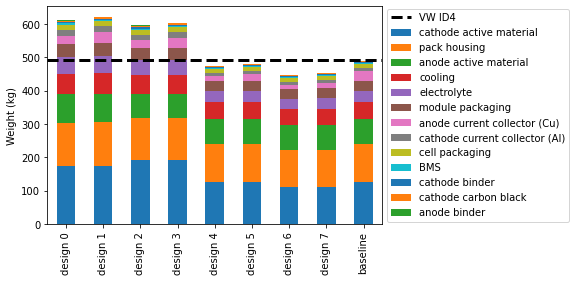

In [51]:

#Plot of the results
import os
def dataframe_components (result_dict, name=None):
    """ Returns material content by component group type"""   
    path = os.path.abspath ('..\\batt_sust_model\data\component_type_linkage.xlsx')
    df_types = pd.read_excel(path, index_col='component')
    result = result_dict['material_content_pack']
    df_types[name] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    df_types.drop('part_off', axis=1, inplace=True)
    return df_types

df_list = [dataframe_components(result_dict_all[x], name=x) for x in result_dict_all.keys()]
df = pd.concat(df_list, axis=1).T.set_axis([f'design {x}' for x in range(len(result_dict_all))])
df.loc['baseline'] = dataframe_components(result_dict).values[:,0]
df.sort_values(by=list(df.index)[0], axis=1, ascending=False).plot.bar(stacked=True)
plt.ylabel('Weight (kg)')
plt.axhline(493, color='black', lw=3, linestyle='--', label='VW ID4')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
#Export results to excel
bd.export_to_excel(result_dict_all, overwrite=True)